In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import sys
sys.path.append('../')
from utils import get_mat
import networkx as nx

### Load data, merge experiments, calculate normalized scores

In [352]:
directory_path = '../our_results'

# Get a list of all CSV files in the directory
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

# Initialize an empty list to store individual DataFrames
dfs = []

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path)
    
    # Define the pattern
    pattern = re.compile(r'([\w-]+)_(\d+\.\d+)_(\d+\.\d+)_(\d+\.\d+)_(\d+)\.csv')

    # Use the pattern to extract values
    match = pattern.match(file)

    # Check if the string matches the pattern
    if match:
        # Extract values from the match object
        name = match.group(1)
        # skip incomplete datasets
        if name in ['Enron', 'Gaza']:
            continue
        else:
            df['dataset'] = name

        e1 = float(match.group(3))
        df['e1'] = e1
        e2 = float(match.group(4))
        df['e2'] = e2
        df['e3'] = 1.0 - e1 - e2
    else:
        print(file + " doesn't match!")
        continue
    
    
    dfs.append(df)

# Concatenate the list of DataFrames into a single DataFrame
dfs = pd.concat(dfs, ignore_index=True)

# take the average of all experiments
dfs = dfs.groupby(['eps', 'N', 'dataset', 'e1', 'e2']).mean().reset_index()
dfs = dfs.drop('exper', axis=1)

dfs

,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3
0,0.5,5.0,Bitcoin,0.1,0.1,0.143892,0.027027,0.051316,3.504935,0.2600,0.978952,0.415654,0.8
1,0.5,5.0,Bitcoin,0.1,0.2,0.150386,0.029730,0.061001,3.429658,0.2600,0.980951,0.436235,0.7
2,0.5,5.0,Bitcoin,0.1,0.3,0.137943,0.016216,0.050437,3.395143,0.2100,0.982516,0.439216,0.6
3,0.5,5.0,Bitcoin,0.1,0.4,0.149094,0.008108,0.063115,3.354910,0.2500,0.972154,0.435042,0.5
4,0.5,5.0,Bitcoin,0.1,0.5,0.147347,0.013514,0.052128,3.343561,0.2400,0.965051,0.434195,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4200,3.5,35.0,Facebook,0.4,0.4,0.211623,0.672500,0.008383,0.332793,0.2625,0.631651,0.326553,0.2
4201,3.5,35.0,Facebook,0.4,0.5,0.242776,0.655000,0.007636,0.351442,0.1500,0.596279,0.342098,0.1
4202,3.5,35.0,Facebook,0.5,0.1,0.154159,0.712500,0.005143,0.451522,0.2125,0.525142,0.410727,0.4
4203,3.5,35.0,Facebook,0.5,0.3,0.207987,0.665000,0.008607,0.363541,0.2250,0.605318,0.335231,0.2


In [353]:
# apply Z-Score Normalization for the metrics and add graph info at the dataset level
datasets = dfs['dataset'].unique()
metrics = cols = ['nmi','evc_overlap','evc_MAE','deg_kl', 'diam_rel','cc_rel','mod_rel']
for dataset in datasets:
    data_path = '../data/' + dataset + '.txt'
    mat0,mid = get_mat(data_path)
    mat0_graph = nx.from_numpy_array(mat0,create_using=nx.Graph)
    dfs.loc[dfs['dataset'] == dataset,'nodes'] = mat0_graph.number_of_nodes()
    dfs.loc[dfs['dataset'] == dataset,'edges'] = mat0_graph.number_of_edges()
    
dfs.loc[:, metrics] = dfs.loc[:, metrics].apply(zscore)
    
dfs['avg deg'] = (dfs['edges']/dfs['nodes'])*2

# invert certain metrics that are better when the values are smaller
for col in ['evc_MAE','deg_kl', 'diam_rel','cc_rel','mod_rel']:
    dfs[col] = -dfs[col]
    
# calculate a score based on normalized metrics. The larger the score the better.
dfs['score'] = dfs[metrics].sum(axis=1)

dfs

,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,avg deg,score
0,0.5,5.0,Bitcoin,0.1,0.1,-0.208352,-1.296366,-2.591954,-0.644413,0.204264,-1.544714,-0.417551,0.8,3783.0,14124.0,7.467090,-6.499086
1,0.5,5.0,Bitcoin,0.1,0.2,-0.115942,-1.287859,-3.351992,-0.605779,0.204264,-1.551262,-0.528941,0.7,3783.0,14124.0,7.467090,-7.237511
2,0.5,5.0,Bitcoin,0.1,0.3,-0.293007,-1.330396,-2.522967,-0.588065,0.529049,-1.556390,-0.545074,0.6,3783.0,14124.0,7.467090,-6.306850
3,0.5,5.0,Bitcoin,0.1,0.4,-0.134325,-1.355918,-3.517868,-0.567416,0.269221,-1.522441,-0.522484,0.5,3783.0,14124.0,7.467090,-7.351232
4,0.5,5.0,Bitcoin,0.1,0.5,-0.159186,-1.338903,-2.655635,-0.561591,0.334178,-1.499172,-0.517900,0.4,3783.0,14124.0,7.467090,-6.398209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4200,3.5,35.0,Facebook,0.4,0.4,0.755463,0.735425,0.777354,0.983638,0.188025,-0.406860,0.064686,0.2,4039.0,88234.0,43.691013,3.097732
4201,3.5,35.0,Facebook,0.4,0.5,1.198778,0.680339,0.835984,0.974067,0.918791,-0.290973,-0.019444,0.1,4039.0,88234.0,43.691013,4.297543
4202,3.5,35.0,Facebook,0.5,0.1,-0.062257,0.861335,1.031622,0.922703,0.512810,-0.057908,-0.390882,0.4,4039.0,88234.0,43.691013,2.817423
4203,3.5,35.0,Facebook,0.5,0.3,0.703725,0.711817,0.759747,0.967857,0.431613,-0.320586,0.017722,0.2,4039.0,88234.0,43.691013,3.271896


In [354]:
# best combo for each dataset
for dataset in datasets:
    display(dfs[dfs['dataset'] == dataset].nlargest(5, "score"))


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,avg deg,score
3174,3.5,10.0,Bitcoin,0.1,0.8,0.319593,0.975123,0.593595,0.698424,0.658963,1.188911,1.221286,0.1,3783.0,14124.0,7.46709,5.655895
3173,3.5,10.0,Bitcoin,0.1,0.7,0.071096,1.128257,0.564903,0.723646,0.853834,0.997711,1.208811,0.2,3783.0,14124.0,7.46709,5.548257
3691,3.5,25.0,Bitcoin,0.1,0.6,0.161018,1.187809,0.650619,0.676698,1.243575,0.309443,1.293940,0.3,3783.0,14124.0,7.46709,5.523102
3354,3.5,15.0,Bitcoin,0.2,0.7,0.547793,0.736914,0.496004,0.621972,1.048704,0.687919,1.312237,0.1,3783.0,14124.0,7.46709,5.451544
3347,3.5,15.0,Bitcoin,0.1,0.8,0.094016,0.924078,0.552593,0.682164,0.853834,0.872326,1.444415,0.1,3783.0,14124.0,7.46709,5.423426


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,avg deg,score
3572,3.5,20.0,CA-HepPh,0.4,0.3,2.006686,1.307267,1.219159,0.811211,0.843840,0.539832,0.645994,0.3,12008.0,118489.0,19.73501,7.373989
3569,3.5,20.0,CA-HepPh,0.3,0.6,2.585529,1.354484,1.198116,0.760563,0.144304,0.312131,0.704771,0.1,12008.0,118489.0,19.73501,7.059898
3913,3.5,30.0,CA-HepPh,0.3,0.4,1.689808,1.551219,1.153310,0.869814,1.143642,-0.036579,0.568032,0.3,12008.0,118489.0,19.73501,6.939245
3754,3.5,25.0,CA-HepPh,0.6,0.3,1.750094,1.396454,1.180775,0.809987,0.693940,0.175894,0.913268,0.1,12008.0,118489.0,19.73501,6.920412
3576,3.5,20.0,CA-HepPh,0.5,0.2,1.410177,1.477771,1.210952,0.834907,0.743906,0.390581,0.731983,0.3,12008.0,118489.0,19.73501,6.800277


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,avg deg,score
3258,3.5,10.0,Chamelon,0.3,0.5,2.614551,1.451540,1.240812,0.593266,0.239695,1.554131,1.172535,0.2,2277.0,31371.0,27.554677,8.866530
3268,3.5,10.0,Chamelon,0.5,0.4,2.426893,1.365692,1.237058,0.587514,0.239695,1.627286,1.295887,0.1,2277.0,31371.0,27.554677,8.780024
3430,3.5,15.0,Chamelon,0.3,0.4,2.333526,1.365692,1.267357,0.633739,0.298747,1.592396,1.201463,0.3,2277.0,31371.0,27.554677,8.692920
3264,3.5,10.0,Chamelon,0.4,0.5,2.179677,1.422924,1.200293,0.559781,0.416850,1.569136,1.230584,0.1,2277.0,31371.0,27.554677,8.579245
3094,3.5,5.0,Chamelon,0.5,0.3,2.354602,1.437232,1.276707,0.577087,0.062540,1.461629,1.268139,0.2,2277.0,31371.0,27.554677,8.437936


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,avg deg,score
3131,3.5,5.0,Congress,0.5,0.4,4.683407,0.271131,-0.554096,-0.000413,0.918791,1.256967,1.003568,0.1,475.0,10222.0,43.04,7.579355
3130,3.5,5.0,Congress,0.5,0.3,3.289986,-0.201032,-0.388818,-0.040111,1.568360,1.457188,1.026582,0.2,475.0,10222.0,43.04,6.712154
3300,3.5,10.0,Congress,0.4,0.5,3.213487,0.271131,-0.363748,-0.002508,0.594006,1.495871,1.303316,0.1,475.0,10222.0,43.04,6.511555
3126,3.5,5.0,Congress,0.4,0.4,3.496664,-0.201032,-0.649406,-0.161926,1.081183,1.540232,1.165381,0.2,475.0,10222.0,43.04,6.271096
3127,3.5,5.0,Congress,0.4,0.5,3.501856,0.349825,-0.594080,0.034910,0.918791,1.225890,0.725305,0.1,475.0,10222.0,43.04,6.162496


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,avg deg,score
3165,3.5,5.0,Facebook,0.5,0.3,2.125462,1.034462,1.390395,0.942693,1.243575,0.942322,0.716602,0.2,4039.0,88234.0,43.691013,8.395512
3162,3.5,5.0,Facebook,0.4,0.4,2.146920,1.105286,1.366251,0.984057,0.350417,0.727035,0.878663,0.2,4039.0,88234.0,43.691013,7.558629
3155,3.5,5.0,Facebook,0.3,0.3,2.032577,1.168242,1.348332,0.983556,0.269221,0.631949,0.772005,0.4,4039.0,88234.0,43.691013,7.205881
3157,3.5,5.0,Facebook,0.3,0.5,2.277980,0.924291,1.353215,0.983550,0.431613,0.445086,0.741433,0.2,4039.0,88234.0,43.691013,7.157167
3161,3.5,5.0,Facebook,0.4,0.3,1.979815,1.121025,1.382777,0.977342,0.106829,0.737918,0.824199,0.3,4039.0,88234.0,43.691013,7.129905


### Multi-Linear Regression model

In [374]:
def linear_regression_train_test_split(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Initialize the linear regression model
    model = LinearRegression()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

    # Plot the predicted vs actual values
    plt.scatter(y_test, y_pred, label='Actual vs Predicted')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='y = x')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values for Multiple Linear Regression')
    plt.legend()
    plt.show()
    
    return model
    

Mean Squared Error: 5.723365619518952
R-squared: 0.7404330626962496


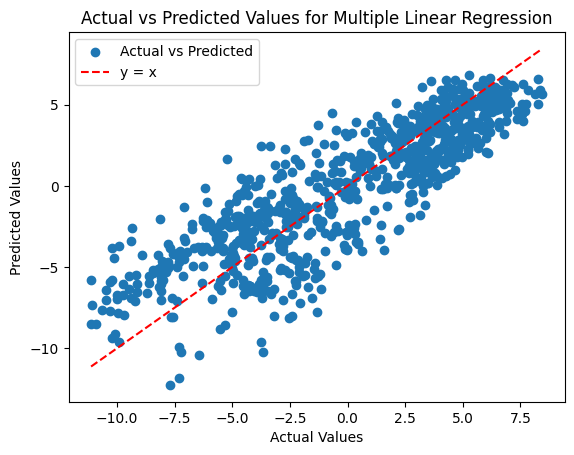

In [375]:
# construct other predictors for the model from parameters
dfs['eps*N'] = dfs['eps'] * dfs['N']
dfs['(eps*N)**2'] = dfs['eps*N']**2
dfs['eps**2'] =  np.square(dfs['eps'])
dfs['e1*e2'] = dfs['e1'] * dfs['e2'] *dfs['eps**2']
dfs['e1**2'] = np.square(dfs['e1'])
dfs['e2**2'] = np.square(dfs['e2'])
dfs['N**2'] = np.square(dfs['N'])
dfs['N**3'] = np.power(dfs['N'], 3)
dfs['N*e1'] = dfs['N'] * (dfs['e1'] - dfs['e1**2'])
dfs['N*e2'] = dfs['N'] * (dfs['e2'] - dfs['e1**2'])
dfs['(e1+e2)/e3'] = dfs['e1'] + dfs['e2'] / dfs['e3']
dfs['e1*eps'] = dfs['e1'] * dfs['eps']
dfs['e2*eps'] = dfs['e2'] * dfs['eps']
dfs['(e1*eps)**2'] = np.square(dfs['e1*eps'])
dfs['(e2*eps)**2'] = np.square(dfs['e2*eps'])
dfs['N*e1*eps'] = dfs['N'] * dfs['e1*eps']
dfs['N*e2*eps'] = dfs['N'] * dfs['e2*eps']
dfs['nodes**2'] = np.square(dfs['nodes'])
dfs['edges**2'] = np.square(dfs['edges'])
dfs['avg deg*e2*eps'] = dfs['avg deg']*dfs['e2*eps']
dfs['avg deg*e1*eps'] = dfs['avg deg']*dfs['e1*eps']
dfs['avg deg*e1/e2'] = dfs['avg deg']*dfs['e1']/dfs['e2']
variables = ['eps', 'N', 'e1', 'e2', 'eps*N', 'e1**2', 'e2**2', 'eps**2', 'e1*e2', 'N*e1', 'N*e2',\
    '(e1+e2)/e3', 'N**2', 'N**3', 'e1*eps', 'e2*eps', '(e1*eps)**2', '(e2*eps)**2', 'N*e1*eps', \
        'N*e2*eps', 'nodes', 'edges', 'avg deg', '(eps*N)**2', 'nodes**2', 'edges**2', 'avg deg*e2*eps', 'avg deg*e1*eps']
# Split the data into features (X) and target variable (y)
X = dfs[variables]
y = dfs['score']

# Initialize the linear regression model
model = linear_regression_train_test_split(X,y)

In [372]:
def linear_regression_all_data(X, y):
    # the model if it had access to all the data, not just training (as good as it's gonna get?)
    model = LinearRegression()

    # Train the model
    model.fit(X, y)

    # Make predictions on the test set
    y_pred = model.predict(X)

    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

    # Plot the predicted vs actual values
    plt.scatter(y, y_pred, label='Actual vs Predicted')
    plt.plot([min(y), max(y)], [min(y), max(y)], '--', color='red', label='y = x')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values for Multiple Linear Regression')
    plt.legend()
    plt.show()
    
    return model

Mean Squared Error: 5.791460391310608
R-squared: 0.741340113990486


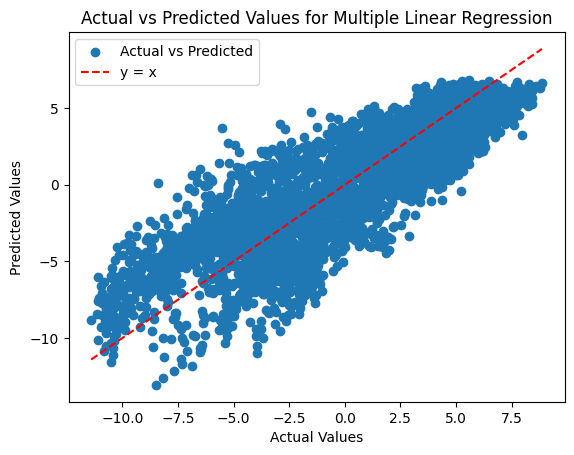

In [376]:
# the model if it had access to all the data, not just training (as good as it's gonna get?)
model2 = linear_regression_all_data(X,y)

In [357]:
# Calculate residuals
residuals = y_test - y_pred

# Calculate MSE for each data point
mse_per_point = np.square(residuals)

# Find the indices of the points with the highest MSE
indices_highest_mse = mse_per_point.nlargest(30).index   # Adjust the number of points to display

test_set = dfs.iloc[y_test.index]
test_set['pred'] = y_pred
test_set['diff'] = np.square(test_set['score'] - test_set['pred'])

/var/folders/r9/dg66n5vj32z_jl7f7k8wjsx80000gn/T/ipykernel_57814/3960316184.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['pred'] = y_pred
/var/folders/r9/dg66n5vj32z_jl7f7k8wjsx80000gn/T/ipykernel_57814/3960316184.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['diff'] = np.square(test_set['score'] - test_set['pred'])


In [358]:
# largest differences in prediction
test_set.sort_values(by='diff', ascending=False)[:17][['eps', 'N', 'dataset', 'e1', 'e2','pred', 'score', 'diff']]

,eps,N,dataset,e1,e2,pred,score,diff
3028,3.5,5.0,Bitcoin,0.7,0.2,3.923578,-5.536947,89.501532
228,0.5,10.0,Congress,0.1,0.1,-11.130484,-3.930089,51.845685
3651,3.5,20.0,Congress,0.6,0.1,1.499131,-5.676604,51.491178
3020,3.5,5.0,Bitcoin,0.5,0.1,2.419950,-4.754703,51.475636
4155,3.5,35.0,Congress,0.3,0.1,-0.041884,-7.022763,48.732668
4166,3.5,35.0,Congress,0.5,0.1,0.201853,-6.644096,46.867028
1758,2.0,5.0,Bitcoin,0.6,0.2,1.528136,-5.207589,45.369986
3997,3.5,30.0,Congress,0.6,0.1,0.534195,-6.198628,45.330907
2708,2.5,5.0,Chamelon,0.2,0.1,-2.646727,-9.368178,45.177900
3022,3.5,5.0,Bitcoin,0.5,0.3,4.965202,-1.536154,42.267635


In [359]:
# After training the model
coefficients = model.coef_  # Coefficients for each feature
intercept = model.intercept_  # Intercept

# Display the equation
equation = f'y = {intercept:.4f}\n'
for i, var in enumerate(variables):
    if coefficients[i] >= 0.0 :
        equation += "+ "
    equation += f'{coefficients[i]:.6f} * '+ var +"\n"
# print("Linear Regression Equation:")
print(equation)

y = -21.2048
+ 3.714869 * eps
+ 0.658129 * N
+ 15.212886 * e1
+ 0.154754 * e2
-0.047483 * eps*N
-11.396422 * e1**2
+ 0.551631 * e2**2
-0.585758 * eps**2
-1.676586 * e1*e2
-0.353870 * N*e1
+ 0.101806 * N*e2
-0.200169 * (e1+e2)/e3
-0.013479 * N**2
+ 0.000103 * N**3
+ 4.945483 * e1*eps
+ 9.799527 * e2*eps
-0.838943 * (e1*eps)**2
-2.027385 * (e2*eps)**2
-0.056107 * N*e1*eps
-0.101334 * N*e2*eps
+ 0.000556 * nodes
+ 0.000123 * edges
-0.000007 * avg deg
+ 0.000252 * (eps*N)**2
+ 0.000000 * nodes**2
-0.000000 * edges**2
+ 0.029507 * avg deg*e2*eps
+ 0.003807 * avg deg*e1*eps



In [360]:
equation = f'y = {intercept:.4f}'
for i, var in enumerate(variables):
    if coefficients[i] >= 0.0 :
        equation += "+ "
    equation += f'{coefficients[i]:.4f} * '+ var +" "
# print("Linear Regression Equation:")
print(equation)

y = -21.2048+ 3.7149 * eps + 0.6581 * N + 15.2129 * e1 + 0.1548 * e2 -0.0475 * eps*N -11.3964 * e1**2 + 0.5516 * e2**2 -0.5858 * eps**2 -1.6766 * e1*e2 -0.3539 * N*e1 + 0.1018 * N*e2 -0.2002 * (e1+e2)/e3 -0.0135 * N**2 + 0.0001 * N**3 + 4.9455 * e1*eps + 9.7995 * e2*eps -0.8389 * (e1*eps)**2 -2.0274 * (e2*eps)**2 -0.0561 * N*e1*eps -0.1013 * N*e2*eps + 0.0006 * nodes + 0.0001 * edges -0.0000 * avg deg + 0.0003 * (eps*N)**2 + 0.0000 * nodes**2 -0.0000 * edges**2 + 0.0295 * avg deg*e2*eps + 0.0038 * avg deg*e1*eps 


### finding the a good set of parameters using scipy.optimize

In [361]:
from scipy.optimize import minimize

# Define the function to minimize
def objective_function(variables):
    eps = 2.5
    nodes = 4000
    edges = 60000
    density = 0
    N, e1, e2, e3 = variables
    y = -30.4020+ 12.8055 * eps + 0.7659 * N + 20.4504 * e1 + 10.7168 * e2 -0.0921 * eps*N -10.6752 * e1**2 -6.9766 * e2**2 -1.9768 * eps**2 -15.6803 * e1*e2 -0.2167 * N*e1 + 0.0960 * N*e2 + 0.1402 * (e1+e2)/e3 -0.0148 * N**2 + 0.0001 * N**3 + 3.1916 * e1*eps + 7.0388 * e2*eps -0.6629 * (e1*eps)**2 -1.6006 * (e2*eps)**2 -0.0997 * N*e1*eps -0.1143 * N*e2*eps + 0.0016 * nodes -0.0001 * edges -0.0000 * density + 0.0004 * (eps*N)**2 

    return -y

# Initial guess for variable values
initial_guess = [30.0, 0.4, 0.4, 0.2]

# Define bounds for the variables if needed
bounds = [ (0, 70), (0.01, 1), (0.1, 1), (0.1, 1)]

# Perform the minimization
result = minimize(objective_function, initial_guess, bounds=bounds, constraints={'type': 'eq', 'fun': lambda x: x[1] + x[2] + x[3]- 1.0 })

# Extract the optimal variable values
optimal_values = result.x

print("Optimal Variable Values:", optimal_values)
print("Minimum Value of y:", result.fun)

Optimal Variable Values: [11.95488459  0.41151761  0.48848239  0.1       ]
Minimum Value of y: -8.151483273200043


### Selecting features automatically with RFE (doesn't actually work as well)

In [32]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt


In [362]:
variables = ['eps', 'N', 'e1', 'e2', 'nodes', 'edges', 'avg deg']
# Split the data into features (X) and target variable (y)
X = dfs[variables]
y = dfs['score']

# Create polynomial features
degree = 4  # Set the degree of polynomial features
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

# # Initialize the linear regression model
# model = LinearRegression()

# # Initialize Recursive Feature Elimination with Cross-Validation (RFECV)
# selector = RFE(estimator=model, step=1, n_features_to_select = 25)

# # Fit RFE on the polynomial features
# selector = selector.fit(X_poly, y)

# # # Get the selected features
# selected_features_indices = selector.support_
# selected_features = X_poly[:,selected_features_indices]

In [363]:
X_feat = pd.DataFrame()

def generateFeatureDF():
    for ic, combo in enumerate(poly.powers_):
        vars = []
        for i, pow in enumerate(combo):
            if pow > 0:
                var = X.columns[i] 
                if pow > 1:
                    var += "**" + str(pow) 
                vars.append(var)
                
        name = '*'.join(vars)
                
        # X_feat[name] = X.apply(lambda row: 
        #     np.sum([np.power(row[X.columns[ri]], combo[ri]) for ri in range(len(combo)) if combo[ri] > 0]), axis=1)
        # print(np.power(X, combo))
        X_feat[name] = np.prod(np.power(X, combo), axis=1)

    
generateFeatureDF()
X_feat  

,,eps,N,e1,e2,nodes,edges,avg deg,eps**2,eps*N,...,nodes**2*avg deg**2,nodes*edges**3,nodes*edges**2*avg deg,nodes*edges*avg deg**2,nodes*avg deg**3,edges**4,edges**3*avg deg,edges**2*avg deg**2,edges*avg deg**3,avg deg**4
0,1.0,0.5,5.0,0.1,0.1,3783.0,14124.0,7.467090,0.25,2.5,...,7.979495e+08,1.065883e+16,5.635119e+12,2.979180e+09,1.575036e+06,3.979521e+16,2.103897e+13,1.112290e+10,5.880467e+06,3.108891e+03
1,1.0,0.5,5.0,0.1,0.2,3783.0,14124.0,7.467090,0.25,2.5,...,7.979495e+08,1.065883e+16,5.635119e+12,2.979180e+09,1.575036e+06,3.979521e+16,2.103897e+13,1.112290e+10,5.880467e+06,3.108891e+03
2,1.0,0.5,5.0,0.1,0.3,3783.0,14124.0,7.467090,0.25,2.5,...,7.979495e+08,1.065883e+16,5.635119e+12,2.979180e+09,1.575036e+06,3.979521e+16,2.103897e+13,1.112290e+10,5.880467e+06,3.108891e+03
3,1.0,0.5,5.0,0.1,0.4,3783.0,14124.0,7.467090,0.25,2.5,...,7.979495e+08,1.065883e+16,5.635119e+12,2.979180e+09,1.575036e+06,3.979521e+16,2.103897e+13,1.112290e+10,5.880467e+06,3.108891e+03
4,1.0,0.5,5.0,0.1,0.5,3783.0,14124.0,7.467090,0.25,2.5,...,7.979495e+08,1.065883e+16,5.635119e+12,2.979180e+09,1.575036e+06,3.979521e+16,2.103897e+13,1.112290e+10,5.880467e+06,3.108891e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4200,1.0,3.5,35.0,0.4,0.4,4039.0,88234.0,43.691013,12.25,122.5,...,3.114096e+10,2.774481e+18,1.373846e+15,6.802899e+11,3.368606e+08,6.060994e+19,3.001235e+16,1.486128e+13,7.358890e+09,3.643917e+06
4201,1.0,3.5,35.0,0.4,0.5,4039.0,88234.0,43.691013,12.25,122.5,...,3.114096e+10,2.774481e+18,1.373846e+15,6.802899e+11,3.368606e+08,6.060994e+19,3.001235e+16,1.486128e+13,7.358890e+09,3.643917e+06
4202,1.0,3.5,35.0,0.5,0.1,4039.0,88234.0,43.691013,12.25,122.5,...,3.114096e+10,2.774481e+18,1.373846e+15,6.802899e+11,3.368606e+08,6.060994e+19,3.001235e+16,1.486128e+13,7.358890e+09,3.643917e+06
4203,1.0,3.5,35.0,0.5,0.3,4039.0,88234.0,43.691013,12.25,122.5,...,3.114096e+10,2.774481e+18,1.373846e+15,6.802899e+11,3.368606e+08,6.060994e+19,3.001235e+16,1.486128e+13,7.358890e+09,3.643917e+06


Mean Squared Error: 2.291256752208056
R-squared: 0.8976672254835975


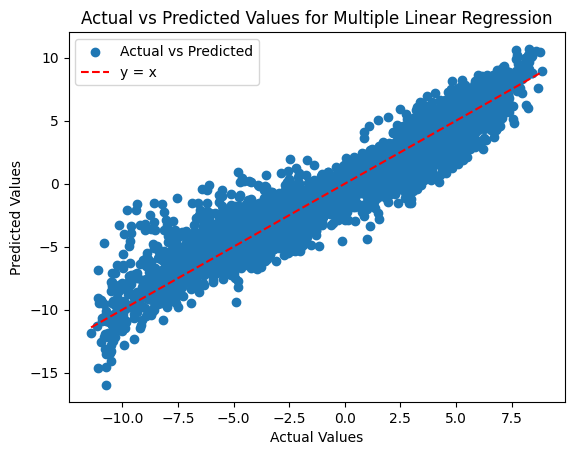

In [377]:
# model with all the polynomial terms
model3 = linear_regression_all_data(X_feat,y)

In [364]:
mag = X_feat.mean() * abs(model3.coef_)
mag = mag.sort_values(ascending=False)
mag

nodes**2*edges**2    2.469213e+08
nodes*edges**3       2.282863e+08
nodes**3*edges       9.736153e+07
edges**4             6.213226e+07
nodes**4             1.279836e+07
                         ...     
avg deg**3           1.377957e-13
e1**2*e2**2          3.833956e-14
e1**3*e2             2.033648e-14
avg deg**2           1.205549e-14
e1*e2**3             7.917330e-15
Length: 330, dtype: float64

In [395]:
X_feat_pruned = X_feat[mag[:70].index]
X_feat_pruned

,nodes**2*edges**2,nodes*edges**3,nodes**3*edges,edges**4,nodes**4,edges**3*avg deg,nodes*edges**2*avg deg,nodes**2*edges*avg deg,edges**3,N*nodes**2*edges,...,e1*e2*edges**2,eps**3*edges,eps*e1*nodes*edges,e2*nodes**2*edges,e1*e2*nodes*edges,eps*e2*nodes**2,eps*e2*edges**2,N*nodes**2*avg deg,N**2*nodes*avg deg,eps*e2*edges*avg deg
0,2.854882e+15,1.065883e+16,7.646571e+14,3.979521e+16,2.048073e+14,2.103897e+13,5.635119e+12,1.509321e+12,2.817560e+12,1.010649e+12,...,1.994874e+06,1765.50,2671554.6,2.021298e+10,534310.92,715554.45,9.974369e+06,5.343109e+08,706200.0,5.273259e+03
1,2.854882e+15,1.065883e+16,7.646571e+14,3.979521e+16,2.048073e+14,2.103897e+13,5.635119e+12,1.509321e+12,2.817560e+12,1.010649e+12,...,3.989748e+06,1765.50,2671554.6,4.042596e+10,1068621.84,1431108.90,1.994874e+07,5.343109e+08,706200.0,1.054652e+04
2,2.854882e+15,1.065883e+16,7.646571e+14,3.979521e+16,2.048073e+14,2.103897e+13,5.635119e+12,1.509321e+12,2.817560e+12,1.010649e+12,...,5.984621e+06,1765.50,2671554.6,6.063895e+10,1602932.76,2146663.35,2.992311e+07,5.343109e+08,706200.0,1.581978e+04
3,2.854882e+15,1.065883e+16,7.646571e+14,3.979521e+16,2.048073e+14,2.103897e+13,5.635119e+12,1.509321e+12,2.817560e+12,1.010649e+12,...,7.979495e+06,1765.50,2671554.6,8.085193e+10,2137243.68,2862217.80,3.989748e+07,5.343109e+08,706200.0,2.109303e+04
4,2.854882e+15,1.065883e+16,7.646571e+14,3.979521e+16,2.048073e+14,2.103897e+13,5.635119e+12,1.509321e+12,2.817560e+12,1.010649e+12,...,9.974369e+06,1765.50,2671554.6,1.010649e+11,2671554.60,3577772.25,4.987184e+07,5.343109e+08,706200.0,2.636629e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4200,1.270047e+17,2.774481e+18,5.813766e+15,6.060994e+19,2.661310e+14,3.001235e+16,1.373846e+15,6.288916e+13,6.869228e+14,5.037925e+13,...,1.245638e+09,3783032.75,498927976.4,5.757629e+11,57020340.16,22838929.40,1.089933e+10,2.494640e+10,216173300.0,5.397046e+06
4201,1.270047e+17,2.774481e+18,5.813766e+15,6.060994e+19,2.661310e+14,3.001235e+16,1.373846e+15,6.288916e+13,6.869228e+14,5.037925e+13,...,1.557048e+09,3783032.75,498927976.4,7.197036e+11,71275425.20,28548661.75,1.362417e+10,2.494640e+10,216173300.0,6.746307e+06
4202,1.270047e+17,2.774481e+18,5.813766e+15,6.060994e+19,2.661310e+14,3.001235e+16,1.373846e+15,6.288916e+13,6.869228e+14,5.037925e+13,...,3.892619e+08,3783032.75,623659970.5,1.439407e+11,17818856.30,5709732.35,2.724834e+09,2.494640e+10,216173300.0,1.349261e+06
4203,1.270047e+17,2.774481e+18,5.813766e+15,6.060994e+19,2.661310e+14,3.001235e+16,1.373846e+15,6.288916e+13,6.869228e+14,5.037925e+13,...,1.167786e+09,3783032.75,623659970.5,4.318222e+11,53456568.90,17129197.05,8.174501e+09,2.494640e+10,216173300.0,4.047784e+06


Mean Squared Error: 3.2547369868056353
R-squared: 0.8589663653460573


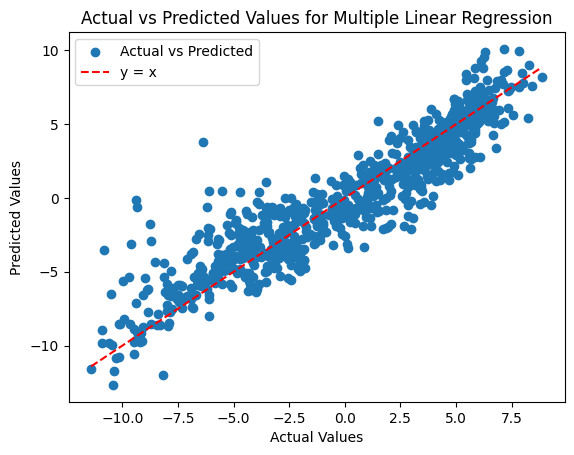

In [386]:
model5 = linear_regression_train_test_split(X_feat_pruned,y)

Mean Squared Error: 2.819104738125949
R-squared: 0.8740923254337369


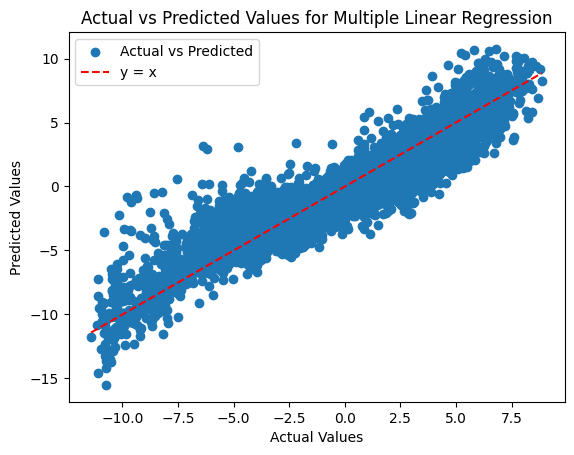

In [396]:
# the model if it had access to all the data, not just training (as good as it's gonna get?)
final_model = linear_regression_all_data(X_feat_pruned,y)

In [409]:
mag = (X_feat_pruned.mean() * final_model.coef_)
mag = mag.sort_values(key=(lambda x:abs(x)),ascending=False)
display(mag[:15])

nodes*edges**3            1.668791e+10
nodes**2*edges**2        -1.475700e+10
edges**4                 -4.771513e+09
nodes**3*edges            3.122337e+09
edges**3*avg deg         -3.952543e+08
nodes**4                  1.144951e+08
nodes*edges**2*avg deg   -2.514081e+06
edges**3                 -6.284176e+05
nodes**2*edges*avg deg   -5.750457e+03
N*nodes*edges**2         -3.502762e+03
N*nodes**2*edges          3.179295e+03
eps*nodes*edges**2       -3.136656e+03
eps*nodes**2*edges        3.015660e+03
nodes*edges**2           -1.438837e+03
N*edges**3                9.348933e+02
dtype: float64

In [403]:
X_feat_pruned.mean() * (final_model.coef_)

nodes**2*edges**2      -1.475700e+10
nodes*edges**3          1.668791e+10
nodes**3*edges          3.122337e+09
edges**4               -4.771513e+09
nodes**4                1.144951e+08
                            ...     
eps*e2*nodes**2         2.899889e+00
eps*e2*edges**2        -5.721076e+00
N*nodes**2*avg deg     -3.589287e-02
N**2*nodes*avg deg     -4.529380e+00
eps*e2*edges*avg deg    3.372425e+00
Length: 70, dtype: float64

In [87]:
from sklearn.feature_selection import RFECV


rfecv = RFECV(estimator=model, step=1, cv = 2)

# Fit the RFECV instance to the data
rfecv.fit(X_poly, y)

# Print the optimal number of features
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 9


In [88]:
# # Get the selected features
selected_features_indices = rfecv.support_
selected_features = X_poly[:,selected_features_indices]
X_feat = pd.DataFrame()

generateFeatureDF()
X_feat

,e1,e2,eps*e2,e1**2,e2**2,eps*e2**2,e1**2*e2,e1*e2**2,e2**3
0,0.1,0.1,0.05,0.01,0.01,0.005,0.001,0.001,0.001
1,0.1,0.2,0.10,0.01,0.04,0.020,0.002,0.004,0.008
2,0.1,0.3,0.15,0.01,0.09,0.045,0.003,0.009,0.027
3,0.1,0.4,0.20,0.01,0.16,0.080,0.004,0.016,0.064
4,0.1,0.5,0.25,0.01,0.25,0.125,0.005,0.025,0.125
...,...,...,...,...,...,...,...,...,...
4152,0.4,0.4,1.40,0.16,0.16,0.560,0.064,0.064,0.064
4153,0.4,0.5,1.75,0.16,0.25,0.875,0.080,0.100,0.125
4154,0.5,0.1,0.35,0.25,0.01,0.035,0.025,0.005,0.001
4155,0.5,0.3,1.05,0.25,0.09,0.315,0.075,0.045,0.027


### Create binary pairs

In [368]:
pairwise_df = pd.DataFrame()
features = ['eps', 'N', 'e1', 'e2', 'e3', 'nodes', 'edges', 'density']

lst = []
for dataset in datasets:
    for ep in dfs['eps'].unique():
        cur = dfs[(dfs['dataset'] == dataset) & (dfs['eps'] == ep)]
        for index1, row1 in cur.iterrows():
            for index2, row2 in cur.iterrows():
                # print(index1, index2)
                if index1 > index2:
                    better = row1['score'] > row2['score']
                    lst.append([index1, index2, better])
                    if (len(lst)%100 == 0):
                        print(len(lst))
                    # print(better)
                    # pairwise_df = pairwise_df/.append({'param1':row1[features].tolist(), 'param2':row2[features].tolist(), '1>2':better}, ignore_index=True)
                else:
                    break
        

pairwise_df
            

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600


KeyboardInterrupt: 

In [238]:
for dataset in datasets:
    for ep in dfs['eps'].unique():
        cur = dfs[(dfs['dataset'] == dataset) & (dfs['eps'] == ep)][:10]
        display(cur)

,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
0,0.5,5.0,Bitcoin,0.1,0.1,-0.209719,-1.300213,-2.585954,-0.636514,0.186175,-1.567797,-0.439159,0.8,3783.0,14124.0,3.733545,-6.553179
1,0.5,5.0,Bitcoin,0.1,0.2,-0.117820,-1.291723,-3.343080,-0.598086,0.186175,-1.574377,-0.551557,0.7,3783.0,14124.0,3.733545,-7.290468
2,0.5,5.0,Bitcoin,0.1,0.3,-0.293906,-1.334174,-2.517231,-0.580466,0.513646,-1.579530,-0.567836,0.6,3783.0,14124.0,3.733545,-6.359498
3,0.5,5.0,Bitcoin,0.1,0.4,-0.136102,-1.359644,-3.508321,-0.559928,0.251670,-1.545412,-0.545042,0.5,3783.0,14124.0,3.733545,-7.402779
4,0.5,5.0,Bitcoin,0.1,0.5,-0.160825,-1.342664,-2.649391,-0.554134,0.317164,-1.522027,-0.540416,0.4,3783.0,14124.0,3.733545,-6.452293
5,0.5,5.0,Bitcoin,0.1,0.6,-0.090340,-1.359644,-2.602529,-0.435268,-0.010307,-1.499682,-0.340465,0.3,3783.0,14124.0,3.733545,-6.338235
6,0.5,5.0,Bitcoin,0.1,0.7,0.117773,-1.368134,-1.934457,-0.290193,-0.010307,-1.417232,-0.255106,0.2,3783.0,14124.0,3.733545,-5.157656
7,0.5,5.0,Bitcoin,0.1,0.8,0.263510,-1.359644,-2.928727,-0.562044,-0.272283,-4.447056,-0.760943,0.1,3783.0,14124.0,3.733545,-10.067188
8,0.5,5.0,Bitcoin,0.2,0.1,-0.521385,-1.334174,-1.591710,-0.127457,0.186175,-1.537291,-0.412003,0.7,3783.0,14124.0,3.733545,-5.337844
9,0.5,5.0,Bitcoin,0.2,0.2,-0.416317,-1.325683,-1.945311,-0.250139,0.513646,-1.524372,-0.641416,0.6,3783.0,14124.0,3.733545,-5.589593


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
1672,2.0,5.0,Bitcoin,0.1,0.1,-0.544855,-1.266252,-2.246631,-0.058083,1.103092,-1.593920,-0.245732,0.8,3783.0,14124.0,3.733545,-4.852381
1673,2.0,5.0,Bitcoin,0.1,0.2,-0.675385,-1.351154,-2.011708,-0.103715,1.037598,-1.592098,-0.324203,0.7,3783.0,14124.0,3.733545,-5.020664
1674,2.0,5.0,Bitcoin,0.1,0.3,-0.503217,-1.342664,-1.999955,-0.057878,0.775622,-1.586906,-0.353149,0.6,3783.0,14124.0,3.733545,-5.068146
1675,2.0,5.0,Bitcoin,0.1,0.4,-0.519642,-1.317193,-2.064091,0.012863,0.906610,-1.558314,-0.298536,0.5,3783.0,14124.0,3.733545,-4.838303
1676,2.0,5.0,Bitcoin,0.1,0.5,-0.629695,-1.325683,-1.658486,0.066140,0.972104,-1.548915,-0.314330,0.4,3783.0,14124.0,3.733545,-4.438864
1677,2.0,5.0,Bitcoin,0.1,0.6,-0.622975,-1.232292,-2.049147,0.230854,0.579140,-1.472758,-0.125344,0.3,3783.0,14124.0,3.733545,-4.692522
1678,2.0,5.0,Bitcoin,0.1,0.7,-0.374817,-0.986078,-1.616168,0.277913,0.120681,-1.375102,-0.128856,0.2,3783.0,14124.0,3.733545,-4.082427
1679,2.0,5.0,Bitcoin,0.1,0.8,-0.462966,-1.003058,-1.054590,0.372153,-0.075801,-1.095840,0.044171,0.1,3783.0,14124.0,3.733545,-3.275931
1680,2.0,5.0,Bitcoin,0.2,0.1,-0.639159,-1.291723,-2.542335,0.050614,1.168586,-1.573222,-0.228339,0.7,3783.0,14124.0,3.733545,-5.055576
1681,2.0,5.0,Bitcoin,0.2,0.2,-0.618630,-1.291723,-2.539737,0.080488,1.168586,-1.555963,-0.095455,0.6,3783.0,14124.0,3.733545,-4.852433


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
2939,3.5,5.0,Bitcoin,0.1,0.1,-0.503813,-1.249272,-2.505581,0.088775,0.972104,-1.579219,-0.276527,0.8,3783.0,14124.0,3.733545,-5.053534
2940,3.5,5.0,Bitcoin,0.1,0.2,-0.472857,-1.130410,-2.529125,0.192115,1.168586,-1.555465,-0.123853,0.7,3783.0,14124.0,3.733545,-4.451009
2941,3.5,5.0,Bitcoin,0.1,0.3,-0.555542,-0.969097,-2.158069,0.344302,1.365069,-1.499121,-0.086316,0.6,3783.0,14124.0,3.733545,-3.558775
2942,3.5,5.0,Bitcoin,0.1,0.4,-0.548823,-0.502139,-1.534330,0.394303,0.972104,-1.322589,-0.043526,0.5,3783.0,14124.0,3.733545,-2.584999
2943,3.5,5.0,Bitcoin,0.1,0.5,-0.275450,-0.018201,-0.541132,0.599999,1.430563,-0.986371,0.023105,0.4,3783.0,14124.0,3.733545,0.232513
2944,3.5,5.0,Bitcoin,0.1,0.6,-0.246071,0.516678,-0.208836,0.671134,0.775622,-0.191093,0.530419,0.3,3783.0,14124.0,3.733545,1.847854
2945,3.5,5.0,Bitcoin,0.1,0.7,-0.169027,0.287444,-0.092836,0.684718,0.644634,-0.325205,0.501553,0.2,3783.0,14124.0,3.733545,1.531280
2946,3.5,5.0,Bitcoin,0.1,0.8,-0.172198,0.372346,0.418914,0.750509,0.120681,0.065867,0.923838,0.1,3783.0,14124.0,3.733545,2.479958
2947,3.5,5.0,Bitcoin,0.2,0.1,-0.521299,-1.257762,-2.778928,0.125447,0.972104,-1.576097,-0.137400,0.7,3783.0,14124.0,3.733545,-5.173935
2948,3.5,5.0,Bitcoin,0.2,0.2,-0.510953,-1.215311,-2.647525,0.245296,0.906610,-1.552279,-0.114406,0.6,3783.0,14124.0,3.733545,-4.888568


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
36,0.5,5.0,CA-HepPh,0.1,0.1,-0.728339,-1.340612,-0.403482,-0.879639,-0.629981,-1.635145,-2.637669,0.8,12008.0,118489.0,9.867505,-8.254868
37,0.5,5.0,CA-HepPh,0.1,0.2,-0.678954,-1.345847,-0.491216,-1.021932,-0.982642,-1.635075,-2.612899,0.7,12008.0,118489.0,9.867505,-8.768566
38,0.5,5.0,CA-HepPh,0.1,0.3,-0.699895,-1.358936,0.384164,-0.636687,-1.033022,-1.633787,-2.596404,0.6,12008.0,118489.0,9.867505,-7.574568
39,0.5,5.0,CA-HepPh,0.1,0.4,-0.672383,-1.343230,-0.967598,-0.902030,-1.083402,-1.634271,-2.610703,0.5,12008.0,118489.0,9.867505,-9.213616
40,0.5,5.0,CA-HepPh,0.1,0.5,-0.719308,-1.351083,-0.446055,-0.839024,-1.033022,-1.634378,-2.625115,0.4,12008.0,118489.0,9.867505,-8.647986
41,0.5,5.0,CA-HepPh,0.1,0.6,-0.608506,-1.353701,-0.723662,-0.999147,-1.083402,-1.634124,-2.609125,0.3,12008.0,118489.0,9.867505,-9.011666
176,0.5,10.0,CA-HepPh,0.1,0.1,-0.616287,-1.324905,-0.679282,-0.364216,-1.033022,-1.631607,-2.420650,0.8,12008.0,118489.0,9.867505,-8.069968
177,0.5,10.0,CA-HepPh,0.1,0.2,-0.628782,-1.301345,-0.773215,-0.375750,-0.982642,-1.630283,-2.390921,0.7,12008.0,118489.0,9.867505,-8.082939
178,0.5,10.0,CA-HepPh,0.1,0.3,-0.600685,-1.330141,-0.732409,-0.304123,-1.184162,-1.629888,-2.399428,0.6,12008.0,118489.0,9.867505,-8.180835
179,0.5,10.0,CA-HepPh,0.1,0.4,-0.618437,-1.330141,-0.651242,-0.328198,-1.184162,-1.627652,-2.392274,0.5,12008.0,118489.0,9.867505,-8.132105


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
1708,2.0,5.0,CA-HepPh,0.3,0.1,-0.638639,-1.275167,-1.000269,-0.374155,-0.327701,-1.631539,-2.363754,0.6,12008.0,118489.0,9.867505,-7.611224
1709,2.0,5.0,CA-HepPh,0.3,0.3,0.072819,1.025875,0.795954,0.363618,-0.176561,-0.338475,-0.910729,0.4,12008.0,118489.0,9.867505,0.832501
1710,2.0,5.0,CA-HepPh,0.3,0.5,0.328364,1.439486,1.164973,0.775686,-0.881882,-0.118285,0.071208,0.2,12008.0,118489.0,9.867505,2.779550
1711,2.0,5.0,CA-HepPh,0.5,0.1,-0.347719,-0.440090,-0.302443,-0.115623,-0.327701,-0.966867,-1.783539,0.4,12008.0,118489.0,9.867505,-4.283982
1712,2.0,5.0,CA-HepPh,0.5,0.3,0.120692,1.300743,1.112146,0.640005,-1.133782,-0.035643,-0.263841,0.2,12008.0,118489.0,9.867505,1.740319
1713,2.0,5.0,CA-HepPh,0.7,0.1,-0.092286,0.842629,0.766202,0.064628,-1.033022,0.107284,-0.664186,0.2,12008.0,118489.0,9.867505,-0.008751
1847,2.0,10.0,CA-HepPh,0.3,0.1,-0.279795,0.591321,0.120816,0.275314,-0.126181,-0.189413,-1.095786,0.6,12008.0,118489.0,9.867505,-0.703724
1848,2.0,10.0,CA-HepPh,0.3,0.3,0.284785,1.457811,1.147051,0.708112,-0.025421,0.200037,-0.007499,0.4,12008.0,118489.0,9.867505,3.764877
1849,2.0,10.0,CA-HepPh,0.3,0.5,0.671628,1.552052,1.173792,0.835157,-0.680361,0.046606,0.186992,0.2,12008.0,118489.0,9.867505,3.785865
1850,2.0,10.0,CA-HepPh,0.5,0.1,0.317206,1.515402,1.248626,0.693710,-0.378081,0.809008,0.108409,0.4,12008.0,118489.0,9.867505,4.314281


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
2975,3.5,5.0,CA-HepPh,0.1,0.1,-0.695852,-0.989827,-0.577279,-0.154220,0.024959,-1.562848,-2.336607,0.8,12008.0,118489.0,9.867505,-6.291674
2976,3.5,5.0,CA-HepPh,0.1,0.2,-0.027922,1.164618,0.868897,0.337865,0.528760,-0.401551,-0.815379,0.7,12008.0,118489.0,9.867505,1.655288
2977,3.5,5.0,CA-HepPh,0.1,0.3,0.465611,1.429015,1.158729,0.706304,0.679900,-0.110021,-0.088477,0.6,12008.0,118489.0,9.867505,4.241061
2978,3.5,5.0,CA-HepPh,0.1,0.4,0.754860,1.491842,1.163886,0.831662,0.478380,-0.179914,0.172733,0.5,12008.0,118489.0,9.867505,4.713449
2979,3.5,5.0,CA-HepPh,0.1,0.5,0.605332,1.483989,1.188817,0.834174,0.428000,0.059951,0.619973,0.4,12008.0,118489.0,9.867505,5.220236
2980,3.5,5.0,CA-HepPh,0.1,0.6,0.720965,1.460429,1.174381,0.868977,-0.226941,0.017581,0.755899,0.3,12008.0,118489.0,9.867505,4.771291
2981,3.5,5.0,CA-HepPh,0.1,0.7,0.978988,1.463047,1.188796,0.895712,-0.378081,0.017006,0.774853,0.2,12008.0,118489.0,9.867505,4.940321
2982,3.5,5.0,CA-HepPh,0.1,0.8,1.047255,1.400219,1.170501,0.896218,-0.629981,0.056168,0.920110,0.1,12008.0,118489.0,9.867505,4.860490
2983,3.5,5.0,CA-HepPh,0.2,0.1,-0.635052,-0.125955,-0.711887,-0.037017,-0.025421,-1.333197,-2.004636,0.7,12008.0,118489.0,9.867505,-4.873166
2984,3.5,5.0,CA-HepPh,0.2,0.2,0.189389,1.279801,1.059834,0.622602,0.730280,-0.106118,-0.589708,0.6,12008.0,118489.0,9.867505,3.186080


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
42,0.5,5.0,Chamelon,0.1,0.1,-1.288862,-1.299441,-1.296579,-1.490581,-1.207062,-1.586763,-2.644959,0.8,2277.0,31371.0,13.777339,-10.814247
43,0.5,5.0,Chamelon,0.1,0.2,-1.324725,-1.356557,-1.244340,-1.673205,-1.326142,-1.589635,-2.680468,0.7,2277.0,31371.0,13.777339,-11.195072
44,0.5,5.0,Chamelon,0.1,0.3,-1.255794,-1.285162,-1.102616,-1.407397,-1.564302,-1.577394,-2.609273,0.6,2277.0,31371.0,13.777339,-10.801938
45,0.5,5.0,Chamelon,0.1,0.4,-1.316127,-1.299441,-1.017764,-1.577810,-1.564302,-1.589672,-2.681861,0.5,2277.0,31371.0,13.777339,-11.046978
46,0.5,5.0,Chamelon,0.1,0.5,-1.285889,-1.299441,-1.378471,-1.737588,-1.564302,-1.579572,-2.647382,0.4,2277.0,31371.0,13.777339,-11.492645
47,0.5,5.0,Chamelon,0.1,0.6,-1.168604,-1.342278,-1.453876,-1.274040,-1.802463,-1.571418,-2.598992,0.3,2277.0,31371.0,13.777339,-11.211670
48,0.5,5.0,Chamelon,0.1,0.7,-1.201217,-1.327999,-0.657241,-1.472273,-1.742923,-1.576465,-2.713245,0.2,2277.0,31371.0,13.777339,-10.691363
49,0.5,5.0,Chamelon,0.1,0.8,-1.190250,-1.327999,-1.320203,-1.300200,-1.683383,-1.566396,-2.614748,0.1,2277.0,31371.0,13.777339,-11.003178
50,0.5,5.0,Chamelon,0.2,0.1,-1.263221,-1.299441,-1.668049,-1.184352,-1.385682,-1.553114,-2.460178,0.7,2277.0,31371.0,13.777339,-10.814037
51,0.5,5.0,Chamelon,0.2,0.2,-1.199285,-1.270883,-1.743439,-1.068090,-1.623843,-1.551388,-2.428581,0.6,2277.0,31371.0,13.777339,-10.885509


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
1372,1.0,5.0,Chamelon,0.1,0.1,-1.264616,-1.285162,-1.648969,-1.366522,-1.087982,-1.574761,-2.489438,0.8,2277.0,31371.0,13.777339,-10.717449
1373,1.0,5.0,Chamelon,0.1,0.2,-1.272284,-1.342278,-1.614142,-1.434914,-1.207062,-1.573799,-2.557469,0.7,2277.0,31371.0,13.777339,-11.001948
1374,1.0,5.0,Chamelon,0.1,0.3,-1.213224,-1.142373,-1.740869,-1.137636,-1.147522,-1.562826,-2.408671,0.6,2277.0,31371.0,13.777339,-10.353121
1375,1.0,5.0,Chamelon,0.1,0.4,-1.187126,-1.185210,-1.617996,-0.894499,-1.326142,-1.531493,-2.385814,0.5,2277.0,31371.0,13.777339,-10.128280
1376,1.0,5.0,Chamelon,0.1,0.5,-1.054323,-0.985306,-1.021377,-0.916788,-1.326142,-1.458360,-2.284582,0.4,2277.0,31371.0,13.777339,-9.046877
1377,1.0,5.0,Chamelon,0.1,0.6,-0.892619,-0.714007,-0.657597,-0.695010,-1.445222,-1.322609,-2.118758,0.3,2277.0,31371.0,13.777339,-7.845823
1378,1.0,5.0,Chamelon,0.1,0.7,-0.530712,-0.685449,-0.651870,-0.161053,-1.564302,-1.035273,-1.774209,0.2,2277.0,31371.0,13.777339,-6.402869
1379,1.0,5.0,Chamelon,0.1,0.8,-0.298663,-0.385593,0.300214,0.076978,-1.683383,-0.934865,-1.596883,0.1,2277.0,31371.0,13.777339,-4.522195
1380,1.0,5.0,Chamelon,0.2,0.1,-1.210037,-1.156652,-1.942255,-1.059428,-1.326142,-1.555996,-2.326418,0.7,2277.0,31371.0,13.777339,-10.576929
1381,1.0,5.0,Chamelon,0.2,0.2,-1.169552,-1.213768,-1.917304,-1.018229,-1.087982,-1.553755,-2.301430,0.6,2277.0,31371.0,13.777339,-10.262019


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
1714,2.0,5.0,Chamelon,0.1,0.1,-1.247343,-1.142373,-1.891401,-1.017430,-0.849822,-1.554780,-2.363339,0.8,2277.0,31371.0,13.777339,-10.066488
1715,2.0,5.0,Chamelon,0.1,0.2,-1.209895,-1.170931,-1.683913,-0.945240,-0.849822,-1.538398,-2.284565,0.7,2277.0,31371.0,13.777339,-9.682763
1716,2.0,5.0,Chamelon,0.1,0.3,-0.444601,-0.000063,0.192581,-0.002917,-0.849822,-0.771852,-1.636343,0.6,2277.0,31371.0,13.777339,-3.513017
1717,2.0,5.0,Chamelon,0.1,0.4,-0.035389,0.485419,0.360466,0.255408,-0.790282,-0.570207,-1.175068,0.5,2277.0,31371.0,13.777339,-1.469651
1718,2.0,5.0,Chamelon,0.1,0.5,0.561677,0.856670,1.071205,0.288120,-0.909362,-0.016189,-0.487748,0.4,2277.0,31371.0,13.777339,1.364373
1719,2.0,5.0,Chamelon,0.1,0.6,1.078491,1.028017,1.093622,0.474242,-0.909362,0.309119,-0.356565,0.3,2277.0,31371.0,13.777339,2.717564
1720,2.0,5.0,Chamelon,0.1,0.7,1.239932,1.099411,1.158232,0.562544,-0.671201,0.569940,-0.140424,0.2,2277.0,31371.0,13.777339,3.818433
1721,2.0,5.0,Chamelon,0.1,0.8,1.119029,0.799554,1.031010,0.532582,-1.147522,0.562833,-0.076573,0.1,2277.0,31371.0,13.777339,2.820914
1722,2.0,5.0,Chamelon,0.2,0.1,-1.215710,-1.142373,-2.115254,-0.767718,-1.087982,-1.537065,-2.144089,0.7,2277.0,31371.0,13.777339,-10.010191
1723,2.0,5.0,Chamelon,0.2,0.2,-1.086951,-0.871075,-1.474652,-0.350867,-0.968902,-1.423106,-2.043502,0.6,2277.0,31371.0,13.777339,-8.219055


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
2645,2.5,5.0,Chamelon,0.1,0.1,-1.227063,-1.242326,-1.953534,-0.968038,-1.028442,-1.552481,-2.250922,0.8,2277.0,31371.0,13.777339,-10.222805
2646,2.5,5.0,Chamelon,0.1,0.2,-0.929498,-0.499824,-0.859049,-0.149975,-0.730742,-1.187455,-1.901727,0.7,2277.0,31371.0,13.777339,-6.258270
2647,2.5,5.0,Chamelon,0.1,0.3,-0.305209,0.342630,0.525720,0.196841,-0.849822,-0.697212,-1.351609,0.6,2277.0,31371.0,13.777339,-2.138661
2648,2.5,5.0,Chamelon,0.1,0.4,0.767194,0.699602,1.070267,0.486956,-0.433041,0.360188,-0.439987,0.5,2277.0,31371.0,13.777339,2.511179
2649,2.5,5.0,Chamelon,0.1,0.5,0.883875,1.028017,1.117780,0.469210,-0.730742,0.443939,-0.005368,0.4,2277.0,31371.0,13.777339,3.206712
2650,2.5,5.0,Chamelon,0.1,0.6,1.205568,1.242200,1.182254,0.601431,-0.849822,0.598321,-0.123699,0.3,2277.0,31371.0,13.777339,3.856253
2651,2.5,5.0,Chamelon,0.1,0.7,1.346362,1.127969,1.170853,0.528767,-0.909362,0.973176,0.459591,0.2,2277.0,31371.0,13.777339,4.697356
2652,2.5,5.0,Chamelon,0.1,0.8,1.471077,1.070853,1.186061,0.535532,-1.087982,1.048520,0.589527,0.1,2277.0,31371.0,13.777339,4.813589
2653,2.5,5.0,Chamelon,0.2,0.1,-1.176080,-1.113816,-1.881096,-0.732166,-0.909362,-1.514466,-2.116251,0.7,2277.0,31371.0,13.777339,-9.443236
2654,2.5,5.0,Chamelon,0.2,0.2,-0.767778,-0.114294,-0.278754,-0.064976,-0.611661,-0.876804,-1.670502,0.6,2277.0,31371.0,13.777339,-4.384769


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
2897,3.0,5.0,Chamelon,0.1,0.1,-1.235877,-1.213768,-1.999848,-0.956139,-0.671201,-1.543459,-2.228016,0.8,2277.0,31371.0,13.777339,-9.848309
2898,3.0,5.0,Chamelon,0.1,0.2,-0.278214,0.471140,0.599208,0.095354,-0.373501,-0.461712,-1.269741,0.7,2277.0,31371.0,13.777339,-1.217467
2899,3.0,5.0,Chamelon,0.1,0.3,0.613881,0.499698,0.732741,0.406718,-0.671201,-0.160949,-0.668472,0.6,2277.0,31371.0,13.777339,0.752415
2900,3.0,5.0,Chamelon,0.1,0.4,1.059478,0.785276,1.000084,0.535136,-0.135341,0.488404,-0.207031,0.5,2277.0,31371.0,13.777339,3.526006
2901,3.0,5.0,Chamelon,0.1,0.5,1.398333,1.156527,1.081180,0.565720,-0.968902,0.783920,0.382645,0.4,2277.0,31371.0,13.777339,4.399422
2902,3.0,5.0,Chamelon,0.1,0.6,1.765873,1.156527,1.256969,0.579051,-0.433041,1.137537,0.422766,0.3,2277.0,31371.0,13.777339,5.885681
2903,3.0,10.0,Chamelon,0.1,0.1,-0.854190,-0.257083,-0.608099,-0.239322,-1.028442,-1.003434,-1.623439,0.8,2277.0,31371.0,13.777339,-5.614009
2904,3.0,10.0,Chamelon,0.1,0.2,0.139594,0.585371,0.892656,0.336022,-0.552121,0.269937,-0.672858,0.7,2277.0,31371.0,13.777339,0.998600
2905,3.0,10.0,Chamelon,0.1,0.3,0.965516,1.256479,1.219006,0.457209,-0.552121,1.309653,0.092066,0.6,2277.0,31371.0,13.777339,4.747806
2906,3.0,10.0,Chamelon,0.1,0.4,1.557237,1.156527,1.249372,0.488452,-0.492581,1.212703,0.467779,0.5,2277.0,31371.0,13.777339,5.639489


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
3011,3.5,5.0,Chamelon,0.1,0.1,-1.161959,-1.128095,-2.021583,-0.593390,-0.909362,-1.513112,-2.147328,0.8,2277.0,31371.0,13.777339,-9.474829
3012,3.5,5.0,Chamelon,0.1,0.2,-0.204331,0.642487,0.639612,0.214175,-0.433041,-0.361538,-1.190256,0.7,2277.0,31371.0,13.777339,-0.692893
3013,3.5,5.0,Chamelon,0.1,0.3,0.722158,0.913786,1.094362,0.363535,-0.254421,0.138622,-0.577889,0.6,2277.0,31371.0,13.777339,2.400151
3014,3.5,5.0,Chamelon,0.1,0.4,1.411712,1.313594,1.170218,0.483553,-0.254421,1.037690,0.080599,0.5,2277.0,31371.0,13.777339,5.242946
3015,3.5,5.0,Chamelon,0.1,0.5,1.454110,1.142248,0.979667,0.595279,-0.730742,0.780638,0.276039,0.4,2277.0,31371.0,13.777339,4.497240
3016,3.5,5.0,Chamelon,0.1,0.6,1.650875,1.199363,1.108281,0.598049,-0.611661,0.970101,0.338272,0.3,2277.0,31371.0,13.777339,5.253280
3017,3.5,5.0,Chamelon,0.1,0.7,2.073875,1.285036,1.182505,0.636877,-0.254421,1.251486,0.420709,0.2,2277.0,31371.0,13.777339,6.596068
3018,3.5,5.0,Chamelon,0.1,0.8,2.294013,1.070853,1.160315,0.563651,-0.611661,1.234692,0.785442,0.1,2277.0,31371.0,13.777339,6.497305
3019,3.5,5.0,Chamelon,0.2,0.1,-0.721114,-0.214246,0.108959,-0.095910,-0.433041,-0.763850,-1.517455,0.7,2277.0,31371.0,13.777339,-3.636658
3020,3.5,5.0,Chamelon,0.2,0.2,0.916865,0.828112,1.129012,0.327739,-0.611661,0.769081,-0.110774,0.6,2277.0,31371.0,13.777339,3.248374


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
78,0.5,5.0,Congress,0.1,0.1,-1.680838,-1.149513,-0.368040,-4.564696,1.234081,-0.806983,-1.170057,0.8,475.0,10222.0,21.52,-8.506045
79,0.5,5.0,Congress,0.1,0.2,-1.552566,-1.149513,-0.421850,-4.525785,1.397816,-0.817317,-1.137499,0.7,475.0,10222.0,21.52,-8.206714
80,0.5,5.0,Congress,0.1,0.3,-1.592548,-1.228047,-0.407971,-4.321011,1.725286,-0.786947,-1.094172,0.6,475.0,10222.0,21.52,-7.705410
81,0.5,5.0,Congress,0.1,0.4,-1.544082,-1.070979,-0.303579,-4.377033,1.725286,-0.747081,-1.010993,0.5,475.0,10222.0,21.52,-7.328461
82,0.5,5.0,Congress,0.1,0.5,-1.422127,-1.228047,-0.417213,-4.781348,1.725286,-0.862154,-1.178364,0.4,475.0,10222.0,21.52,-8.163966
83,0.5,5.0,Congress,0.1,0.6,-1.327524,-1.385114,-0.599835,-3.853387,1.725286,-0.642255,-1.033448,0.3,475.0,10222.0,21.52,-7.116278
84,0.5,5.0,Congress,0.1,0.7,-1.199664,-1.306581,-0.672402,-4.635981,1.561551,-1.045387,-1.348311,0.2,475.0,10222.0,21.52,-8.646775
85,0.5,5.0,Congress,0.1,0.8,-1.066052,-1.385114,-0.827217,-6.494968,1.725286,-1.264337,-1.535586,0.1,475.0,10222.0,21.52,-10.847989
86,0.5,5.0,Congress,0.2,0.1,-1.514306,-1.070979,-0.306805,-3.744752,1.397816,-0.625005,-1.040893,0.7,475.0,10222.0,21.52,-6.904925
87,0.5,5.0,Congress,0.2,0.2,-1.480292,-1.306581,-0.333323,-4.138815,1.561551,-0.665212,-1.042303,0.6,475.0,10222.0,21.52,-7.404976


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
1750,2.0,5.0,Congress,0.1,0.1,-1.762872,-1.385114,-0.684665,-4.551779,0.579140,-0.746291,-1.142129,0.8,475.0,10222.0,21.52,-9.693711
1751,2.0,5.0,Congress,0.1,0.2,-1.711925,-0.992445,-0.812460,-3.262945,0.087934,-0.586276,-0.778323,0.7,475.0,10222.0,21.52,-8.056439
1752,2.0,5.0,Congress,0.1,0.3,-1.461284,-1.070979,-0.478291,-2.609975,0.906610,-0.379088,-0.000388,0.6,475.0,10222.0,21.52,-5.093396
1753,2.0,5.0,Congress,0.1,0.4,-1.182057,-0.599776,-0.434223,-1.603238,0.742875,0.075432,0.310068,0.5,475.0,10222.0,21.52,-2.690918
1754,2.0,5.0,Congress,0.1,0.5,-1.214454,-0.678310,-0.149792,-1.020405,0.579140,0.207323,-0.450364,0.4,475.0,10222.0,21.52,-2.726861
1755,2.0,5.0,Congress,0.1,0.6,-0.451308,0.107029,-0.308200,-0.819732,0.906610,0.522742,-0.106982,0.3,475.0,10222.0,21.52,-0.149842
1756,2.0,5.0,Congress,0.1,0.7,-0.686911,-0.285641,-0.274329,-0.429566,1.070345,0.627877,-0.108970,0.2,475.0,10222.0,21.52,-0.087195
1757,2.0,5.0,Congress,0.1,0.8,0.553482,-0.521242,-0.413739,-0.273332,0.906610,1.004836,0.285013,0.1,475.0,10222.0,21.52,1.541628
1758,2.0,5.0,Congress,0.2,0.1,-1.790669,-0.913911,-0.716176,-3.500873,0.415405,-0.590014,-0.841923,0.7,475.0,10222.0,21.52,-7.938161
1759,2.0,5.0,Congress,0.2,0.2,-1.633047,-0.913911,-0.575238,-2.919554,0.906610,-0.412735,-0.631264,0.6,475.0,10222.0,21.52,-6.179139


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
3047,3.5,5.0,Congress,0.1,0.1,-1.705044,-0.992445,-0.666835,-2.271015,-0.075801,-0.435018,-0.529338,0.8,475.0,10222.0,21.52,-6.675497
3048,3.5,5.0,Congress,0.1,0.2,-1.278731,-0.364174,-0.777737,-1.584603,0.087934,-0.058525,0.680930,0.7,475.0,10222.0,21.52,-3.294907
3049,3.5,5.0,Congress,0.1,0.3,0.271245,-0.285641,-0.246533,-0.641005,-0.075801,0.578527,0.488227,0.6,475.0,10222.0,21.52,0.089019
3050,3.5,5.0,Congress,0.1,0.4,0.354521,0.028495,-0.145719,-0.369367,-0.403271,0.835803,0.087107,0.5,475.0,10222.0,21.52,0.387568
3051,3.5,5.0,Congress,0.1,0.5,0.919631,-0.050039,-0.467171,-0.398976,0.906610,1.075940,0.091956,0.4,475.0,10222.0,21.52,2.077952
3052,3.5,5.0,Congress,0.1,0.6,1.654871,0.421164,-0.633234,-0.227552,1.070345,1.203164,0.395760,0.3,475.0,10222.0,21.52,3.884519
3053,3.5,5.0,Congress,0.1,0.7,1.869046,0.264096,-0.661016,-0.232442,0.415405,1.208726,0.639106,0.2,475.0,10222.0,21.52,3.502922
3054,3.5,5.0,Congress,0.1,0.8,1.460897,0.107029,-1.077025,-0.013137,0.251670,1.217086,0.356781,0.1,475.0,10222.0,21.52,2.303300
3055,3.5,5.0,Congress,0.2,0.1,-1.431567,-0.207107,-0.821654,-1.131190,0.251670,0.048951,0.191049,0.7,475.0,10222.0,21.52,-3.099849
3056,3.5,5.0,Congress,0.2,0.2,-0.110357,-0.128573,-0.082856,-0.549793,1.070345,0.618023,0.497427,0.6,475.0,10222.0,21.52,1.314217


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
114,0.5,5.0,Facebook,0.1,0.1,-1.488706,-1.322287,-0.532959,-2.418788,-0.321404,-1.611567,-2.886873,0.8,4039.0,88234.0,21.845506,-10.582586
115,0.5,5.0,Facebook,0.1,0.2,-1.487325,-1.345847,-0.635800,-2.403128,-0.157668,-1.608962,-2.856548,0.7,4039.0,88234.0,21.845506,-10.495279
116,0.5,5.0,Facebook,0.1,0.3,-1.480063,-1.337994,-0.461592,-2.281014,-0.403271,-1.611003,-2.903785,0.6,4039.0,88234.0,21.845506,-10.478722
117,0.5,5.0,Facebook,0.1,0.4,-1.410399,-1.353701,-0.608569,-2.137993,-0.485139,-1.606417,-2.864267,0.5,4039.0,88234.0,21.845506,-10.466484
118,0.5,5.0,Facebook,0.1,0.5,-1.460940,-1.337994,-0.520242,-2.058583,-0.485139,-1.608076,-2.884827,0.4,4039.0,88234.0,21.845506,-10.355800
119,0.5,5.0,Facebook,0.1,0.6,-1.387994,-1.314434,-0.400212,-2.176259,-0.485139,-1.603923,-2.946043,0.3,4039.0,88234.0,21.845506,-10.314004
120,0.5,5.0,Facebook,0.1,0.7,-1.383566,-1.361554,-0.339625,-2.273117,-0.567006,-1.603135,-2.973870,0.2,4039.0,88234.0,21.845506,-10.501874
121,0.5,5.0,Facebook,0.1,0.8,-1.358962,-1.385114,-0.517459,-1.851785,-0.730742,-1.596381,-2.898787,0.1,4039.0,88234.0,21.845506,-10.339229
122,0.5,5.0,Facebook,0.2,0.1,-1.444979,-1.298727,-0.781248,-2.269253,-0.485139,-1.603534,-2.699810,0.7,4039.0,88234.0,21.845506,-10.582690
123,0.5,5.0,Facebook,0.2,0.2,-1.440295,-1.330141,-0.825959,-2.210770,-0.321404,-1.603606,-2.734013,0.6,4039.0,88234.0,21.845506,-10.466187


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
1786,2.0,5.0,Facebook,0.1,0.1,-1.539785,-1.267314,-1.091402,-2.110504,0.661007,-1.601222,-2.729592,0.8,4039.0,88234.0,21.845506,-9.678812
1787,2.0,5.0,Facebook,0.1,0.2,-1.386345,-0.819671,-0.524913,-1.107930,0.906610,-1.500006,-2.519884,0.7,4039.0,88234.0,21.845506,-6.952139
1788,2.0,5.0,Facebook,0.1,0.3,-0.469781,0.554672,0.673810,0.065677,0.824743,-1.079224,-1.887837,0.6,4039.0,88234.0,21.845506,-1.317941
1789,2.0,5.0,Facebook,0.1,0.4,0.248342,0.570378,0.712353,0.574787,0.906610,-0.899730,-0.954888,0.5,4039.0,88234.0,21.845506,1.157852
1790,2.0,5.0,Facebook,0.1,0.5,1.001586,0.805980,1.195742,0.865617,0.169802,-0.396903,-0.432209,0.4,4039.0,88234.0,21.845506,3.209615
1791,2.0,5.0,Facebook,0.1,0.6,1.353249,0.931634,1.189190,0.929081,0.333537,-0.203830,-0.032521,0.3,4039.0,88234.0,21.845506,4.500341
1792,2.0,5.0,Facebook,0.1,0.7,1.512596,0.782420,1.085732,0.928137,0.169802,-0.235541,-0.087905,0.2,4039.0,88234.0,21.845506,4.155242
1793,2.0,5.0,Facebook,0.1,0.8,1.342379,0.570378,1.096384,0.936930,0.006067,-0.237762,-0.005259,0.1,4039.0,88234.0,21.845506,3.709117
1794,2.0,5.0,Facebook,0.2,0.1,-1.533315,-1.094539,-1.229328,-1.866312,1.315948,-1.587108,-2.646996,0.7,4039.0,88234.0,21.845506,-8.641650
1795,2.0,5.0,Facebook,0.2,0.2,-1.163813,-0.050039,-0.133265,-0.736392,0.988478,-1.382543,-2.288251,0.6,4039.0,88234.0,21.845506,-4.765824


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
3083,3.5,5.0,Facebook,0.1,0.1,-1.357797,-0.780404,-0.553305,-1.201674,1.479683,-1.528656,-2.510512,0.8,4039.0,88234.0,21.845506,-6.452664
3084,3.5,5.0,Facebook,0.1,0.2,0.258118,0.853100,0.900787,0.620667,0.497272,-0.653559,-0.914911,0.7,4039.0,88234.0,21.845506,1.561474
3085,3.5,5.0,Facebook,0.1,0.3,0.852902,0.648912,0.616808,0.848946,0.497272,-0.600033,-0.370158,0.6,4039.0,88234.0,21.845506,2.494650
3086,3.5,5.0,Facebook,0.1,0.4,1.488624,0.845247,0.926903,0.933337,0.742875,-0.332425,-0.159414,0.5,4039.0,88234.0,21.845506,4.445147
3087,3.5,5.0,Facebook,0.1,0.5,1.906418,0.955194,1.078416,0.963843,0.251670,-0.032373,0.200507,0.4,4039.0,88234.0,21.845506,5.323675
3088,3.5,5.0,Facebook,0.1,0.6,2.066512,0.703886,0.739298,0.979909,0.661007,-0.154811,0.196073,0.3,4039.0,88234.0,21.845506,5.191875
3089,3.5,5.0,Facebook,0.1,0.7,1.819387,0.562525,0.591057,0.974750,0.824743,-0.360953,-0.043198,0.2,4039.0,88234.0,21.845506,4.368311
3090,3.5,5.0,Facebook,0.1,0.8,2.187136,0.625352,0.804629,0.965995,0.415405,-0.183855,0.345075,0.1,4039.0,88234.0,21.845506,5.159737
3091,3.5,5.0,Facebook,0.2,0.1,-0.341415,0.978754,1.174954,-0.142085,0.661007,-0.528157,-1.294999,0.7,4039.0,88234.0,21.845506,0.508060
3092,3.5,5.0,Facebook,0.2,0.2,0.752095,0.963048,1.084505,0.855857,0.824743,-0.188548,-0.407659,0.6,4039.0,88234.0,21.845506,3.884040


In [ ]:
for dataset in datasets:
    for ep in dfs['eps'].unique():
        cur = dfs[(dfs['dataset'] == dataset) & (dfs['eps'] == ep)][:10]

### Adding Laplacian noise

In [285]:
from numpy.random import laplace

laplace(0, 1/0.01, 1)

array([-30.82798064])